In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [2]:
tf.random.set_seed(42)

### 生成数据

In [3]:
def fx(x):
    w = tf.constant([4,-3],dtype=tf.float32)
    
    return tf.reduce_sum(x*w,axis=1)+5.0 + tf.random.normal(shape=(x.shape[0],))

In [4]:
x = tf.random.normal(shape=(1000,2))
y = fx(x)

In [5]:
y

<tf.Tensor: id=19, shape=(1000,), dtype=float32, numpy=
array([ 8.92197609e+00,  9.63948727e+00, -1.05637288e+00,  1.14638972e+00,
        1.04363880e+01,  3.85014892e-01,  8.03162289e+00, -3.43564153e-02,
        1.20295992e+01,  6.34049702e+00,  4.83365154e+00, -2.83426344e-01,
        9.08669186e+00,  6.15849400e+00,  6.82055950e+00,  6.79942751e+00,
        7.78949976e+00,  9.56624317e+00,  1.38121057e+00,  2.15927649e+00,
       -1.27185321e+00,  6.16015196e+00,  3.43141341e+00,  7.94718647e+00,
        8.58274841e+00,  8.45251751e+00,  3.38319230e+00, -1.97959375e+00,
        7.85936975e+00,  9.16922283e+00,  1.27816067e+01, -1.92345500e+00,
        6.87556744e+00,  1.84179795e+00,  4.00552559e+00,  1.32602520e+01,
        7.15980196e+00,  2.55554438e+00,  7.73447514e+00,  3.70592237e-01,
        1.36396008e+01,  4.68194008e+00,  1.31079378e+01, -6.76856041e+00,
        5.69010115e+00, -6.19727254e-01,  2.46892643e+00, -3.60582352e+00,
        3.99964881e+00,  4.25462008e+00,  9.

## 梯度下降
$$ x\leftarrow x - \eta f'(x)$$

现在假设损失函数为：
$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x})$$
其中$f_i(\mathbf{x})$是有关索引为i的训练数据点的损失函数。
广义上，每次迭代可以随机均匀采样一个由训练数据点索引所组成的小批量$\mathcal{B}$。类似地，我们可以使用
$$\nabla f_\mathcal{B}(\mathbf{x}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}\nabla f_i(\mathbf{x})$$
来更新$\mathbf{x}$：
$\mathbf{x} := \mathbf{x} - \eta \nabla f_\mathcal{B}(\mathbf{x})$,(把上式中 $\nabla f_\mathcal{B}(\mathbf{x})$代进来， 这里会出现 learn_rate / batch_size)

其中$|\mathcal{B}|$代表批量中索引数量 ，$\eta$ （取正数）称作学习率或步长。同样，小批量随机梯度$\nabla f_\mathcal{B}(\mathbf{x})$也是对梯度 $\nabla f(\mathbf{x})$的无偏估计:$$\mathbb{E}_\mathcal{B} \nabla f_\mathcal{B}(\mathbf{x}) = \nabla f(\mathbf{x}).$$.

In [6]:
def sgd(grads,params,lr,batch_size):
    '''如果batch_size 为1时 此时是随机梯度下降，如果是全部数据大小为梯度下降，
    如果1<batch_size<n 此时是小批量随机梯度下降'''
    params = params - lr * grads / batch_size
    return params

In [7]:
ds = tf.data.Dataset.from_tensor_slices((x,y))

In [8]:
def create_ds(x,y,batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    return ds.shuffle(1000).batch(batch_size).repeat()

In [9]:
ds = create_ds(x,y,10)

In [10]:
exp_x,exp_y = next(iter(ds))
exp_x,exp_y

(<tf.Tensor: id=45, shape=(10, 2), dtype=float32, numpy=
 array([[ 0.988863  , -0.778669  ],
        [ 0.45387512, -0.623685  ],
        [-0.4791881 ,  0.23417848],
        [ 0.5503331 ,  0.4620713 ],
        [-0.51244026,  0.7084891 ],
        [-0.77041024, -0.49471846],
        [ 0.43681848, -0.8851238 ],
        [-1.6600039 ,  0.5864756 ],
        [ 1.1788347 ,  0.86087   ],
        [ 0.00949245,  0.20773652]], dtype=float32)>,
 <tf.Tensor: id=46, shape=(10,), dtype=float32, numpy=
 array([11.1072855,  8.610628 ,  0.7651397,  5.177281 ,  0.969326 ,
         1.7328231,  8.79996  , -3.553817 ,  8.566045 ,  6.4832673],
       dtype=float32)>)

In [11]:
def model(x,w,b):
    return tf.reduce_sum(x * w,axis=1) + b

In [12]:
def loss(y,y_hat):
    return tf.reduce_mean((y - y_hat) ** 2) /2

In [13]:
def trainer(x,y,epcho=5,batch_size=10,lr=0.01):
    steps = 1000 // batch_size
    ds = create_ds(x,y,batch_size=batch_size)
    w = tf.ones(shape=(1,2))
    b = tf.zeros(shape=(1,))
    losses = []
    for i in range(epcho):
        k = 0
        for x,label in ds:
            k += 1
            with tf.GradientTape() as tap:
                tap.watch([w,b])
                y_hat = model(x,w,b)
                l = loss(label,y_hat)
            grads = tap.gradient(l,[w,b])
            w = sgd(grads[0],w,lr,batch_size)
            b = sgd(grads[1],b,lr,batch_size)
            losses.append(l.numpy())
            if k == steps:
                break
        y_hat = model(x,w,b)
        l = loss(label,y_hat)
        print("epcho:", i+1 , "  loss:",l.numpy())
    print("w:",w.numpy()," b: ",b.numpy())
    return losses

In [14]:
def plt_losses(losses):
    plt.plot(range(len(losses)),losses)

In [15]:
## 小批量随机梯度下降
losses = trainer(x,y,10,100,0.1)

epcho: 1   loss: 24.516613
epcho: 2   loss: 23.04641
epcho: 3   loss: 26.200047
epcho: 4   loss: 20.432673
epcho: 5   loss: 21.125853
epcho: 6   loss: 20.264397
epcho: 7   loss: 20.348082
epcho: 8   loss: 20.27572
epcho: 9   loss: 19.149363
epcho: 10   loss: 18.048798
w: [[1.2849451  0.63742197]]  b:  [0.4867438]


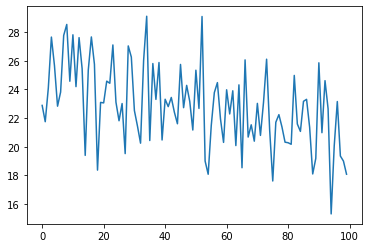

In [16]:
plt_losses(losses)

epcho: 1   loss: 0.008152484
w: [[ 3.6934824 -2.9109106]]  b:  [4.8560476]


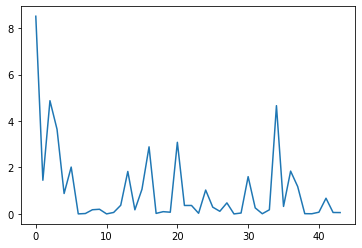

In [17]:
## 随机梯度下降
losses = trainer(x,y,1,1,0.1)
plt_losses(losses[6:50])

In [18]:
## 梯度下降
losses = trainer(x,y,10,1000,0.5)

epcho: 1   loss: 25.151657
epcho: 2   loss: 25.126875
epcho: 3   loss: 25.102121
epcho: 4   loss: 25.077383
epcho: 5   loss: 25.052677
epcho: 6   loss: 25.027996
epcho: 7   loss: 25.003336
epcho: 8   loss: 24.978703
epcho: 9   loss: 24.954098
epcho: 10   loss: 24.929514
w: [[1.0149375  0.98103756]]  b:  [0.02554107]


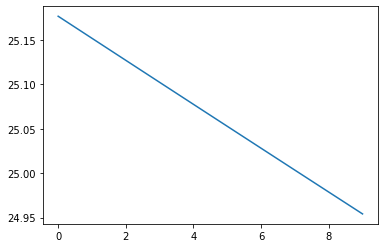

In [19]:
plt_losses(losses)